In [12]:
%pip install newsapi-python
%pip install --upgrade transformers
%pip install bert-for-sequence-classification
from newsapi import NewsApiClient
import json
import torch
import os
print(torch.__version__)

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: C:\Users\franc\OneDrive\Documents\Admin\Universiteit\Akademies\Year 3\Data Science 346\Project\DS346proj\myenv\Scripts\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: C:\Users\franc\OneDrive\Documents\Admin\Universiteit\Akademies\Year 3\Data Science 346\Project\DS346proj\myenv\Scripts\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
2.4.1+cpu



[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: C:\Users\franc\OneDrive\Documents\Admin\Universiteit\Akademies\Year 3\Data Science 346\Project\DS346proj\myenv\Scripts\python.exe -m pip install --upgrade pip


In [15]:

# Function to fetch articles from API or load from local file
def get_articles():
    if os.path.exists('articles.json'):
        # Load from local file if it exists
        with open('articles.json', 'r') as json_file:
            articles = json.load(json_file)
            print("Loaded articles from local file.")
    else:
        # Fetch from API if local file does not exist
        newsapi = NewsApiClient(api_key='cc7b577d5b4b4462b6eef124170903b1')
        articles = newsapi.get_everything(q='Trump OR Harris',
                                          from_param='2024-09-19',
                                          to='2024-10-01',
                                          language='en',
                                          sort_by='relevancy',
                                          page_size=2)
        # Save to local file
        with open('articles.json', 'w') as json_file:
            json.dump(articles, json_file, indent=4)
        print("Articles fetched from API and saved locally.")
    
    return articles

# Call the function to get articles
articles = get_articles()

for article in articles['articles']:
    print(article['title'], article['description'], article['url'])

Loaded articles from local file.
Trump Says He’ll Prosecute Google If He Retakes Power The former president insists Google is hiding positive news stories about him. https://gizmodo.com/trump-says-hell-prosecute-google-if-he-retakes-power-2000504499
Kamala Harris accepts CNN invitation for TV debate Trump has yet to comment on the proposed rematch, but has said previously he wouldn't debate Harris again. https://www.bbc.com/news/articles/cwyejk91d2qo


In [19]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_words = set(stopwords.words('english'))

def preprocess(text):
    words = word_tokenize(text.lower())
    words = [WordNetLemmatizer().lemmatize(word) for word in words if word.isalpha()]
    return ' '.join([word for word in words if word not in stop_words])

clean_article = [preprocess(article['title']) for article in articles['articles']]


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\franc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\franc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\franc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\franc\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [20]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import word_tokenize
import nltk

# Download required resources
nltk.download('vader_lexicon')
nltk.download('punkt')

# Initialize Sentiment Intensity Analyzer
sid = SentimentIntensityAnalyzer()

# Define lists of keywords for Trump and Kamala Harris
trump_keywords = ['trump', 'donald trump', 'president trump']
kamala_keywords = ['kamala', 'kamala harris', 'vice president harris']

def calculate_sentiment(article):
    # Tokenize article text into words
    words = word_tokenize(article.lower())
    
    # Initialize sentiment scores for Trump and Kamala
    trump_score = 0
    kamala_score = 0
    
    # Analyze each sentence or word for sentiment, focusing on Trump and Kamala keywords
    for word in words:
        # If Trump-related word is found, calculate sentiment for Trump
        if word in trump_keywords:
            sentiment = sid.polarity_scores(article)
            trump_score += sentiment['compound']  # Compound is a normalized overall sentiment score
            
        # If Kamala-related word is found, calculate sentiment for Kamala
        elif word in kamala_keywords:
            sentiment = sid.polarity_scores(article)
            kamala_score += sentiment['compound']  # Use compound score for Kamala sentiment
    
    # Return both Trump and Kamala scores
    return trump_score, kamala_score

# Process each article and calculate the combined score
for article in clean_article:
    trump_score, kamala_score = calculate_sentiment(article)
    
    # Calculate the final combined score (Trump score - Kamala score)
    combined_score = trump_score - kamala_score
    
    print(f"Article: {article}")
    print(f"Trump Score: {trump_score}, Kamala Harris Score: {kamala_score}")
    print(f"Combined Score (Trump - Kamala): {combined_score}\n")




Article: trump say prosecute google retake power
Trump Score: -0.4019, Kamala Harris Score: 0
Combined Score (Trump - Kamala): -0.4019

Article: kamala harris accepts cnn invitation tv debate
Trump Score: 0, Kamala Harris Score: 0.3182
Combined Score (Trump - Kamala): -0.3182



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\franc\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\franc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:

from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
from nltk.corpus import wordnet as wn
import pandas as pd

nrc = pd.read_csv('NRC-Emotion-Lexicon-Wordlevel-v0.92.txt', sep='\t', names=["word", "emotion", "association"])
nrc = nrc.pivot(index='word', columns='emotion', values='association').reset_index()

def get_emotions(text):
    words = word_tokenize(text.lower())
    emotions = {emotion: 0 for emotion in nrc.columns[1:]}
    for word in words:
        if word in nrc['word'].values:
            word_emotions = nrc[nrc['word'] == word].iloc[0, 1:]
            for emotion in word_emotions.index:
                emotions[emotion] += word_emotions[emotion]
    return emotions

for article in clean_article:
    emotions = get_emotions(article)
    print(article, emotions)


trump say prosecute google retake power {'anger': np.int64(1), 'anticipation': np.int64(0), 'disgust': np.int64(0), 'fear': np.int64(1), 'joy': np.int64(0), 'negative': np.int64(1), 'positive': np.int64(0), 'sadness': np.int64(1), 'surprise': np.int64(1), 'trust': np.int64(0)}
kamala harris accepts cnn invitation tv debate {'anger': np.int64(0), 'anticipation': np.int64(1), 'disgust': np.int64(0), 'fear': np.int64(0), 'joy': np.int64(0), 'negative': np.int64(0), 'positive': np.int64(2), 'sadness': np.int64(0), 'surprise': np.int64(0), 'trust': np.int64(0)}


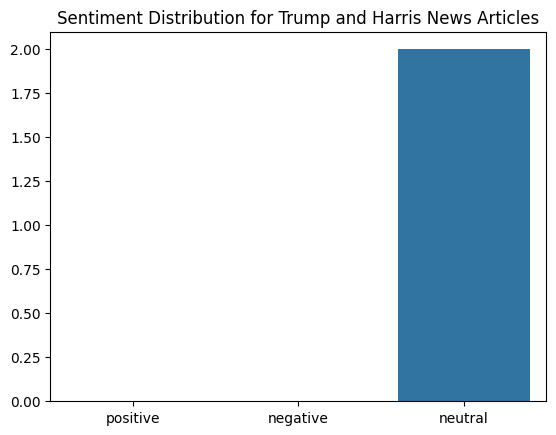

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sentiments = ['positive', 'negative', 'neutral']
counts = [len([s for s in clean_article if sid.polarity_scores(s)['compound'] > 0.5]),
          len([s for s in clean_article if sid.polarity_scores(s)['compound'] < -0.5]),
          len([s for s in clean_article if -0.5 <= sid.polarity_scores(s)['compound'] <= 0.5])]

sns.barplot(x=sentiments, y=counts)
plt.title('Sentiment Distribution for Trump and Harris News Articles')
plt.show()
